In [135]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_recall_curve, precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten, SimpleRNN, ReLU
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
%matplotlib inline

### Dados
- são carregados os dados pre-procesados no notebook: Data pre-processing

In [2]:
datos = pd.read_csv("./data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


### Divisão dos dados para o treinamento da rede GAN
- para o treinamento da rede GAN só serão necessários os genes conhecidos na literatura como genes de referência.

- Do artigo https://biodatamining.biomedcentral.com/articles/10.1186/s13040-017-0150-8 são selecionados 6 genes de referência: cysG, hcaT, idnT, rrsA, ihfB, ssrA. Sendo que o gene idnT não é tomado em conta ja que é um outliers com base nos demais genes.
- Do artigo https://link.springer.com/article/10.1007/s10482-015-0524-1 são selecionados 8 genes os quais estão validados em dois ou mais estudos: gyrA, recA, rpoB, rpoA, gyrB, rho, ftsZ, secA. Também são selecionados 7 genes que são validados uma o só testados em estudos: rpoC, gmk, adk, rpoD, dnaG, glnA, recF.

In [3]:
obj_rg = open("./data/reference_genes.txt")
rg = obj_rg.read().splitlines()
rg.remove("idnT")
print("quantidade de genes de referência:", len(rg))
print(rg)

quantidade de genes de referência: 20
['cysG', 'hcaT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [4]:
X_train = datos.loc[rg]
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


### Preparação dos dados de treinamento
- Os dados de treinamento são levados a um intervalo de [-1,1], devido a que a função de activação da rede genradora é tanh

In [5]:
max_val = 1
min_val = -1
min_train = np.min(X_train)
max_train = np.max(X_train)
X_train = ((X_train - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


In [6]:
datos = ((datos - min_train)/(max_train - min_train))*(max_val - min_val) + min_val
datos.shape

(4205, 9)

In [7]:
datos = datos.drop(rg)
datos.shape

(4185, 9)

### Construção da rede GAN
- Duas redes são feitas para a implementação da rede, uma chamada geradora e a outra discriminadora

In [8]:
class Generator():
    def __init__(self, noise_input, out_dim, optimizerG):
        self.noise_input = noise_input
        self.out_dim = out_dim
        self.optimizerG = optimizerG
        
    def generator(self):
        """
        noise_input: vector con los datos de la distribuición inicial
        out_dim: dimension de la salida esperada, por ejemplo si es una imagen
                 en escala de gris, sería out_dim: (32,32,1)
        Retorna el modelo Generador
        """
        model = Sequential()
        model.add(Dense(50, input_shape=(self.noise_input,)))
        model.add(Dense(150))
        model.add(Dense(np.prod(self.out_dim), activation="tanh"))
        model.add(Reshape(self.out_dim))
        return model
    
    def compileG(self):
        Gr = self.generator()
        Gr.compile(loss="binary_crossentropy", optimizer= self.optimizerG)
        return Gr

In [9]:
noise_input = 50
optimizerG = Adam(lr=0.0001, beta_1=0.5)
obj_G = Generator(noise_input, (9,), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()

Dimension del ruido de entrada:  50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [10]:
G.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 150)               7650      
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 1359      
_________________________________________________________________
reshape (Reshape)            (None, 9)                 0         
Total params: 11,559
Trainable params: 11,559
Non-trainable params: 0
_________________________________________________________________


In [11]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0], noise_input))
print("Dimensão dos dados de entrada:", noise.shape)
data_sint = G.predict(noise)
print("Dimensão dos dados generados:", data_sint.shape)

Dimensão dos dados de entrada: (20, 50)
Dimensão dos dados generados: (20, 9)


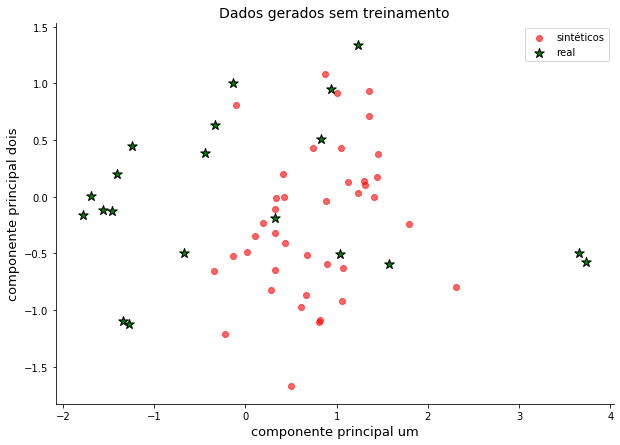

In [12]:
pca_real = PCA(n_components=2)
X_train_pca = pca_real.fit_transform(X_train)

noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0]*2, noise_input))
fig1 = plt.figure(figsize=(10,7))
ax1 = fig1.add_subplot()
ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
plt.title("Dados gerados sem treinamento", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
x_noise = G.predict(noise)
X_sint_pca = pca_real.transform(x_noise)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintéticos", alpha=.6)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [13]:
class Discriminator():
    
    def __init__(self, input_dim, optimizerD):
        self.input_dim = input_dim
        self.optimizerD = optimizerD
    
    def discriminator(self):
        """
        input_dim: dimension de los datos de entrada,
                   por ejemplo si es una imagen en escala de gris,
                   sería input_dim: (32,32,1)
        """
        model = Sequential()
        model.add(Dense(32, input_shape=self.input_dim))
        model.add(LeakyReLU(alpha=0.2)) #función rectificadora
        model.add(Dense(32))
        model.add(Dropout(.1))
        model.add(Flatten())
        #activación sigmoid ya que se precisa establecer si es 0 ó 1.
        model.add(Dense(1, activation='sigmoid'))
        return model
    
    def compileD(self):
        Dr = self.discriminator()
        Dr.compile(loss="binary_crossentropy", optimizer=optimizerD, metrics=["accuracy"])
        return Dr

In [14]:
optimizerD = Adam(lr=0.0001, beta_1=0.5)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [16]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [136]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    precision = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        d_bacth_loss = []
        g_bacth_loss = []
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_bacth_loss.append(D.train_on_batch(x_combined_batch, y_combined_batch)[0])
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_bacth_loss.append(gan.train_on_batch(noise, y_mislabled))
        
        #precision
        X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
        X_comb = np.concatenate((X_train, X_sint))
        y_comb = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_sint.shape[0],1))))
        y_predict = D.predict_classes(X_comb)
        #f1_lag = f1_score(y_test, y_predict)
        precision.append(precision_score(y_comb, y_predict))
        #fscore.append(f1_lag)
        t_f = time()
        t = t_f - t_i
        t_i = time()
        #d_loss.append(np.mean(np.array(d_bacth_loss)))
        #g_loss.append(np.mean(np.array(g_bacth_loss)))
        d_loss.append(d_bacth_loss[-1])
        g_loss.append(g_bacth_loss[-1])
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
        #if np.mean((D.predict(X_train) - np.ones((20,1)))**2) <= 0.15:
        #    break
    return g_loss, d_loss, precision

In [352]:
noise_input = 50
#Gerador
optimizerG = SGD(lr=0.00011, momentum=0.92, decay=0.0001/2000)
#optimizerG = SGD(lr=0.00011, momentum=0.92)
obj_G = Generator(noise_input, (X_train.shape[1],), optimizerG)
print("Dimension del ruido de entrada: ",noise_input)
G = obj_G.compileG()
# Discriminador
optimizerD = SGD(lr=0.001, momentum=0.9, decay=0.001/2000)
#optimizerD = SGD(lr=0.001, momentum=0.9)
objD = Discriminator((X_train.shape[1],), optimizerD)
D = objD.compileD()

gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Dimension del ruido de entrada:  50
Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_29 (Sequential)   (None, 9)                 11559     
_________________________________________________________________
sequential_30 (Sequential)   (None, 1)                 1409      
Total params: 12,968
Trainable params: 11,559
Non-trainable params: 1,409
_________________________________________________________________


In [353]:
ep = 2000
g_loss, d_loss, precision = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan,
                       noise_input=noise_input)

epoch:[1/2000] [Discriminator::d_loss: 0.730820],[Generator::loss: 0.734654], 3.396801[sec]
epoch:[2/2000] [Discriminator::d_loss: 0.760274],[Generator::loss: 0.688454], 0.013399[sec]
epoch:[3/2000] [Discriminator::d_loss: 0.703533],[Generator::loss: 0.690698], 0.013309[sec]
epoch:[4/2000] [Discriminator::d_loss: 0.720979],[Generator::loss: 0.751000], 0.013292[sec]
epoch:[5/2000] [Discriminator::d_loss: 0.758501],[Generator::loss: 0.592036], 0.013417[sec]
epoch:[6/2000] [Discriminator::d_loss: 0.775741],[Generator::loss: 0.791983], 0.013299[sec]
epoch:[7/2000] [Discriminator::d_loss: 0.720788],[Generator::loss: 0.668621], 0.013330[sec]
epoch:[8/2000] [Discriminator::d_loss: 0.719013],[Generator::loss: 0.744736], 0.013346[sec]
epoch:[9/2000] [Discriminator::d_loss: 0.729857],[Generator::loss: 0.704138], 0.013251[sec]
epoch:[10/2000] [Discriminator::d_loss: 0.742170],[Generator::loss: 0.674841], 0.013336[sec]
epoch:[11/2000] [Discriminator::d_loss: 0.776794],[Generator::loss: 0.635121], 

epoch:[90/2000] [Discriminator::d_loss: 0.634884],[Generator::loss: 0.664251], 0.014960[sec]
epoch:[91/2000] [Discriminator::d_loss: 0.637405],[Generator::loss: 0.717290], 0.016409[sec]
epoch:[92/2000] [Discriminator::d_loss: 0.604660],[Generator::loss: 0.666247], 0.014342[sec]
epoch:[93/2000] [Discriminator::d_loss: 0.640195],[Generator::loss: 0.721404], 0.013744[sec]
epoch:[94/2000] [Discriminator::d_loss: 0.610541],[Generator::loss: 0.638699], 0.013052[sec]
epoch:[95/2000] [Discriminator::d_loss: 0.602261],[Generator::loss: 0.663573], 0.013065[sec]
epoch:[96/2000] [Discriminator::d_loss: 0.629961],[Generator::loss: 0.733199], 0.013076[sec]
epoch:[97/2000] [Discriminator::d_loss: 0.605233],[Generator::loss: 0.641511], 0.013150[sec]
epoch:[98/2000] [Discriminator::d_loss: 0.613685],[Generator::loss: 0.675448], 0.013263[sec]
epoch:[99/2000] [Discriminator::d_loss: 0.620560],[Generator::loss: 0.683490], 0.013174[sec]
epoch:[100/2000] [Discriminator::d_loss: 0.635864],[Generator::loss: 0

epoch:[179/2000] [Discriminator::d_loss: 0.598053],[Generator::loss: 0.839651], 0.014874[sec]
epoch:[180/2000] [Discriminator::d_loss: 0.609869],[Generator::loss: 0.790873], 0.015518[sec]
epoch:[181/2000] [Discriminator::d_loss: 0.604123],[Generator::loss: 0.739471], 0.013366[sec]
epoch:[182/2000] [Discriminator::d_loss: 0.589239],[Generator::loss: 0.818240], 0.013344[sec]
epoch:[183/2000] [Discriminator::d_loss: 0.582653],[Generator::loss: 0.809925], 0.019099[sec]
epoch:[184/2000] [Discriminator::d_loss: 0.562034],[Generator::loss: 0.680356], 0.013396[sec]
epoch:[185/2000] [Discriminator::d_loss: 0.624553],[Generator::loss: 0.723254], 0.014276[sec]
epoch:[186/2000] [Discriminator::d_loss: 0.597286],[Generator::loss: 0.771221], 0.013243[sec]
epoch:[187/2000] [Discriminator::d_loss: 0.551605],[Generator::loss: 0.795756], 0.013662[sec]
epoch:[188/2000] [Discriminator::d_loss: 0.602282],[Generator::loss: 0.755733], 0.013419[sec]
epoch:[189/2000] [Discriminator::d_loss: 0.576160],[Generato

epoch:[268/2000] [Discriminator::d_loss: 0.592376],[Generator::loss: 0.835310], 0.015556[sec]
epoch:[269/2000] [Discriminator::d_loss: 0.573566],[Generator::loss: 0.857762], 0.016091[sec]
epoch:[270/2000] [Discriminator::d_loss: 0.550480],[Generator::loss: 0.748450], 0.014035[sec]
epoch:[271/2000] [Discriminator::d_loss: 0.633612],[Generator::loss: 0.735485], 0.015553[sec]
epoch:[272/2000] [Discriminator::d_loss: 0.528443],[Generator::loss: 0.839458], 0.013380[sec]
epoch:[273/2000] [Discriminator::d_loss: 0.569105],[Generator::loss: 0.865652], 0.013487[sec]
epoch:[274/2000] [Discriminator::d_loss: 0.560812],[Generator::loss: 0.758585], 0.013326[sec]
epoch:[275/2000] [Discriminator::d_loss: 0.567884],[Generator::loss: 0.795422], 0.013542[sec]
epoch:[276/2000] [Discriminator::d_loss: 0.573902],[Generator::loss: 0.729123], 0.013278[sec]
epoch:[277/2000] [Discriminator::d_loss: 0.566756],[Generator::loss: 0.890718], 0.013372[sec]
epoch:[278/2000] [Discriminator::d_loss: 0.595126],[Generato

epoch:[358/2000] [Discriminator::d_loss: 0.539786],[Generator::loss: 0.779544], 0.014535[sec]
epoch:[359/2000] [Discriminator::d_loss: 0.555455],[Generator::loss: 0.883484], 0.016573[sec]
epoch:[360/2000] [Discriminator::d_loss: 0.568970],[Generator::loss: 0.891151], 0.013763[sec]
epoch:[361/2000] [Discriminator::d_loss: 0.555313],[Generator::loss: 0.756411], 0.013579[sec]
epoch:[362/2000] [Discriminator::d_loss: 0.512702],[Generator::loss: 0.894030], 0.013323[sec]
epoch:[363/2000] [Discriminator::d_loss: 0.550819],[Generator::loss: 0.785785], 0.013277[sec]
epoch:[364/2000] [Discriminator::d_loss: 0.615877],[Generator::loss: 0.786730], 0.013508[sec]
epoch:[365/2000] [Discriminator::d_loss: 0.528671],[Generator::loss: 0.851871], 0.013391[sec]
epoch:[366/2000] [Discriminator::d_loss: 0.551897],[Generator::loss: 0.809708], 0.013385[sec]
epoch:[367/2000] [Discriminator::d_loss: 0.518149],[Generator::loss: 0.841415], 0.013287[sec]
epoch:[368/2000] [Discriminator::d_loss: 0.573126],[Generato

epoch:[448/2000] [Discriminator::d_loss: 0.538083],[Generator::loss: 0.784202], 0.018419[sec]
epoch:[449/2000] [Discriminator::d_loss: 0.564857],[Generator::loss: 0.810770], 0.015855[sec]
epoch:[450/2000] [Discriminator::d_loss: 0.574136],[Generator::loss: 0.788509], 0.013975[sec]
epoch:[451/2000] [Discriminator::d_loss: 0.554316],[Generator::loss: 0.810289], 0.013440[sec]
epoch:[452/2000] [Discriminator::d_loss: 0.628514],[Generator::loss: 0.696112], 0.013202[sec]
epoch:[453/2000] [Discriminator::d_loss: 0.534964],[Generator::loss: 0.876581], 0.013557[sec]
epoch:[454/2000] [Discriminator::d_loss: 0.563691],[Generator::loss: 0.956733], 0.013219[sec]
epoch:[455/2000] [Discriminator::d_loss: 0.569746],[Generator::loss: 0.774093], 0.013219[sec]
epoch:[456/2000] [Discriminator::d_loss: 0.506497],[Generator::loss: 0.869331], 0.013330[sec]
epoch:[457/2000] [Discriminator::d_loss: 0.535151],[Generator::loss: 0.870705], 0.013457[sec]
epoch:[458/2000] [Discriminator::d_loss: 0.543238],[Generato

epoch:[538/2000] [Discriminator::d_loss: 0.560528],[Generator::loss: 0.920795], 0.014432[sec]
epoch:[539/2000] [Discriminator::d_loss: 0.627277],[Generator::loss: 0.772313], 0.016814[sec]
epoch:[540/2000] [Discriminator::d_loss: 0.646153],[Generator::loss: 0.891488], 0.013678[sec]
epoch:[541/2000] [Discriminator::d_loss: 0.515952],[Generator::loss: 0.908303], 0.013435[sec]
epoch:[542/2000] [Discriminator::d_loss: 0.593697],[Generator::loss: 1.018891], 0.013533[sec]
epoch:[543/2000] [Discriminator::d_loss: 0.566818],[Generator::loss: 0.676379], 0.013243[sec]
epoch:[544/2000] [Discriminator::d_loss: 0.568984],[Generator::loss: 0.852390], 0.013417[sec]
epoch:[545/2000] [Discriminator::d_loss: 0.552036],[Generator::loss: 0.981918], 0.013848[sec]
epoch:[546/2000] [Discriminator::d_loss: 0.580570],[Generator::loss: 0.875528], 0.013457[sec]
epoch:[547/2000] [Discriminator::d_loss: 0.603141],[Generator::loss: 0.964269], 0.013378[sec]
epoch:[548/2000] [Discriminator::d_loss: 0.575352],[Generato

epoch:[628/2000] [Discriminator::d_loss: 0.514712],[Generator::loss: 0.969641], 0.016485[sec]
epoch:[629/2000] [Discriminator::d_loss: 0.620793],[Generator::loss: 0.875554], 0.014600[sec]
epoch:[630/2000] [Discriminator::d_loss: 0.570836],[Generator::loss: 0.960057], 0.014206[sec]
epoch:[631/2000] [Discriminator::d_loss: 0.611157],[Generator::loss: 0.856143], 0.013516[sec]
epoch:[632/2000] [Discriminator::d_loss: 0.664026],[Generator::loss: 0.931079], 0.013343[sec]
epoch:[633/2000] [Discriminator::d_loss: 0.576461],[Generator::loss: 0.794383], 0.013207[sec]
epoch:[634/2000] [Discriminator::d_loss: 0.603114],[Generator::loss: 0.914538], 0.013340[sec]
epoch:[635/2000] [Discriminator::d_loss: 0.568492],[Generator::loss: 0.919026], 0.013195[sec]
epoch:[636/2000] [Discriminator::d_loss: 0.526048],[Generator::loss: 0.960898], 0.013206[sec]
epoch:[637/2000] [Discriminator::d_loss: 0.601410],[Generator::loss: 0.835260], 0.013525[sec]
epoch:[638/2000] [Discriminator::d_loss: 0.614649],[Generato

epoch:[718/2000] [Discriminator::d_loss: 0.596080],[Generator::loss: 0.865784], 0.015241[sec]
epoch:[719/2000] [Discriminator::d_loss: 0.576435],[Generator::loss: 0.895793], 0.016384[sec]
epoch:[720/2000] [Discriminator::d_loss: 0.670223],[Generator::loss: 0.917423], 0.013493[sec]
epoch:[721/2000] [Discriminator::d_loss: 0.591600],[Generator::loss: 0.889973], 0.013488[sec]
epoch:[722/2000] [Discriminator::d_loss: 0.659575],[Generator::loss: 0.864836], 0.013238[sec]
epoch:[723/2000] [Discriminator::d_loss: 0.597359],[Generator::loss: 0.885286], 0.013332[sec]
epoch:[724/2000] [Discriminator::d_loss: 0.651672],[Generator::loss: 0.884488], 0.013259[sec]
epoch:[725/2000] [Discriminator::d_loss: 0.637504],[Generator::loss: 0.771385], 0.013319[sec]
epoch:[726/2000] [Discriminator::d_loss: 0.584304],[Generator::loss: 0.872554], 0.013314[sec]
epoch:[727/2000] [Discriminator::d_loss: 0.622390],[Generator::loss: 0.989249], 0.013344[sec]
epoch:[728/2000] [Discriminator::d_loss: 0.553859],[Generato

epoch:[808/2000] [Discriminator::d_loss: 0.627163],[Generator::loss: 0.711906], 0.018101[sec]
epoch:[809/2000] [Discriminator::d_loss: 0.625638],[Generator::loss: 0.850701], 0.015427[sec]
epoch:[810/2000] [Discriminator::d_loss: 0.687865],[Generator::loss: 1.041810], 0.013744[sec]
epoch:[811/2000] [Discriminator::d_loss: 0.644583],[Generator::loss: 0.866536], 0.013344[sec]
epoch:[812/2000] [Discriminator::d_loss: 0.607571],[Generator::loss: 0.881523], 0.013384[sec]
epoch:[813/2000] [Discriminator::d_loss: 0.619112],[Generator::loss: 0.859895], 0.013312[sec]
epoch:[814/2000] [Discriminator::d_loss: 0.621444],[Generator::loss: 1.065025], 0.013223[sec]
epoch:[815/2000] [Discriminator::d_loss: 0.584267],[Generator::loss: 0.867999], 0.013389[sec]
epoch:[816/2000] [Discriminator::d_loss: 0.600210],[Generator::loss: 0.875484], 0.013520[sec]
epoch:[817/2000] [Discriminator::d_loss: 0.569100],[Generator::loss: 0.865322], 0.013158[sec]
epoch:[818/2000] [Discriminator::d_loss: 0.656079],[Generato

epoch:[898/2000] [Discriminator::d_loss: 0.673875],[Generator::loss: 0.868447], 0.018562[sec]
epoch:[899/2000] [Discriminator::d_loss: 0.672057],[Generator::loss: 0.756553], 0.016612[sec]
epoch:[900/2000] [Discriminator::d_loss: 0.784262],[Generator::loss: 0.844262], 0.013600[sec]
epoch:[901/2000] [Discriminator::d_loss: 0.689619],[Generator::loss: 0.710104], 0.013436[sec]
epoch:[902/2000] [Discriminator::d_loss: 0.588275],[Generator::loss: 0.913513], 0.013349[sec]
epoch:[903/2000] [Discriminator::d_loss: 0.616172],[Generator::loss: 0.867087], 0.013280[sec]
epoch:[904/2000] [Discriminator::d_loss: 0.645604],[Generator::loss: 0.920887], 0.013223[sec]
epoch:[905/2000] [Discriminator::d_loss: 0.616837],[Generator::loss: 0.882156], 0.013461[sec]
epoch:[906/2000] [Discriminator::d_loss: 0.608830],[Generator::loss: 0.796950], 0.013294[sec]
epoch:[907/2000] [Discriminator::d_loss: 0.621141],[Generator::loss: 0.966292], 0.013301[sec]
epoch:[908/2000] [Discriminator::d_loss: 0.769557],[Generato

epoch:[988/2000] [Discriminator::d_loss: 0.615626],[Generator::loss: 0.815965], 0.015026[sec]
epoch:[989/2000] [Discriminator::d_loss: 0.590594],[Generator::loss: 0.791780], 0.015815[sec]
epoch:[990/2000] [Discriminator::d_loss: 0.703729],[Generator::loss: 0.684806], 0.013715[sec]
epoch:[991/2000] [Discriminator::d_loss: 0.693687],[Generator::loss: 0.859409], 0.013325[sec]
epoch:[992/2000] [Discriminator::d_loss: 0.691233],[Generator::loss: 0.690846], 0.013239[sec]
epoch:[993/2000] [Discriminator::d_loss: 0.684660],[Generator::loss: 0.877963], 0.013376[sec]
epoch:[994/2000] [Discriminator::d_loss: 0.671469],[Generator::loss: 0.724978], 0.013582[sec]
epoch:[995/2000] [Discriminator::d_loss: 0.651507],[Generator::loss: 0.990547], 0.013419[sec]
epoch:[996/2000] [Discriminator::d_loss: 0.671900],[Generator::loss: 0.756755], 0.013355[sec]
epoch:[997/2000] [Discriminator::d_loss: 0.671630],[Generator::loss: 0.682433], 0.013236[sec]
epoch:[998/2000] [Discriminator::d_loss: 0.655959],[Generato

epoch:[1078/2000] [Discriminator::d_loss: 0.703531],[Generator::loss: 0.850441], 0.019653[sec]
epoch:[1079/2000] [Discriminator::d_loss: 0.640106],[Generator::loss: 0.887732], 0.015101[sec]
epoch:[1080/2000] [Discriminator::d_loss: 0.644532],[Generator::loss: 0.897659], 0.013277[sec]
epoch:[1081/2000] [Discriminator::d_loss: 0.696843],[Generator::loss: 0.913298], 0.013569[sec]
epoch:[1082/2000] [Discriminator::d_loss: 0.630480],[Generator::loss: 0.808234], 0.013644[sec]
epoch:[1083/2000] [Discriminator::d_loss: 0.713475],[Generator::loss: 0.673944], 0.013275[sec]
epoch:[1084/2000] [Discriminator::d_loss: 0.705200],[Generator::loss: 0.949707], 0.013249[sec]
epoch:[1085/2000] [Discriminator::d_loss: 0.661346],[Generator::loss: 0.722580], 0.013221[sec]
epoch:[1086/2000] [Discriminator::d_loss: 0.696991],[Generator::loss: 0.831374], 0.013321[sec]
epoch:[1087/2000] [Discriminator::d_loss: 0.676879],[Generator::loss: 0.782740], 0.013199[sec]
epoch:[1088/2000] [Discriminator::d_loss: 0.662303

epoch:[1168/2000] [Discriminator::d_loss: 0.670231],[Generator::loss: 0.768001], 0.014632[sec]
epoch:[1169/2000] [Discriminator::d_loss: 0.695119],[Generator::loss: 0.801471], 0.015936[sec]
epoch:[1170/2000] [Discriminator::d_loss: 0.647095],[Generator::loss: 0.844402], 0.013358[sec]
epoch:[1171/2000] [Discriminator::d_loss: 0.718280],[Generator::loss: 0.927079], 0.013405[sec]
epoch:[1172/2000] [Discriminator::d_loss: 0.695294],[Generator::loss: 0.781543], 0.013322[sec]
epoch:[1173/2000] [Discriminator::d_loss: 0.678626],[Generator::loss: 0.823412], 0.013223[sec]
epoch:[1174/2000] [Discriminator::d_loss: 0.607452],[Generator::loss: 0.679843], 0.013308[sec]
epoch:[1175/2000] [Discriminator::d_loss: 0.660442],[Generator::loss: 0.854974], 0.013442[sec]
epoch:[1176/2000] [Discriminator::d_loss: 0.665805],[Generator::loss: 1.010047], 0.013132[sec]
epoch:[1177/2000] [Discriminator::d_loss: 0.654753],[Generator::loss: 0.772945], 0.013185[sec]
epoch:[1178/2000] [Discriminator::d_loss: 0.729632

epoch:[1258/2000] [Discriminator::d_loss: 0.677104],[Generator::loss: 0.719565], 0.018256[sec]
epoch:[1259/2000] [Discriminator::d_loss: 0.720745],[Generator::loss: 0.831200], 0.016273[sec]
epoch:[1260/2000] [Discriminator::d_loss: 0.688707],[Generator::loss: 0.756417], 0.013588[sec]
epoch:[1261/2000] [Discriminator::d_loss: 0.685795],[Generator::loss: 0.753416], 0.013045[sec]
epoch:[1262/2000] [Discriminator::d_loss: 0.668351],[Generator::loss: 0.695128], 0.015733[sec]
epoch:[1263/2000] [Discriminator::d_loss: 0.720258],[Generator::loss: 0.756657], 0.013285[sec]
epoch:[1264/2000] [Discriminator::d_loss: 0.700761],[Generator::loss: 0.707750], 0.013527[sec]
epoch:[1265/2000] [Discriminator::d_loss: 0.698748],[Generator::loss: 0.823554], 0.013132[sec]
epoch:[1266/2000] [Discriminator::d_loss: 0.697359],[Generator::loss: 0.747477], 0.013483[sec]
epoch:[1267/2000] [Discriminator::d_loss: 0.730795],[Generator::loss: 0.689065], 0.013368[sec]
epoch:[1268/2000] [Discriminator::d_loss: 0.709642

epoch:[1348/2000] [Discriminator::d_loss: 0.694395],[Generator::loss: 0.687769], 0.014779[sec]
epoch:[1349/2000] [Discriminator::d_loss: 0.679128],[Generator::loss: 0.826904], 0.015737[sec]
epoch:[1350/2000] [Discriminator::d_loss: 0.696661],[Generator::loss: 0.788692], 0.013520[sec]
epoch:[1351/2000] [Discriminator::d_loss: 0.723271],[Generator::loss: 0.849418], 0.013704[sec]
epoch:[1352/2000] [Discriminator::d_loss: 0.710059],[Generator::loss: 0.858740], 0.013401[sec]
epoch:[1353/2000] [Discriminator::d_loss: 0.650571],[Generator::loss: 0.814952], 0.013112[sec]
epoch:[1354/2000] [Discriminator::d_loss: 0.648480],[Generator::loss: 0.779194], 0.013253[sec]
epoch:[1355/2000] [Discriminator::d_loss: 0.690626],[Generator::loss: 0.693566], 0.013282[sec]
epoch:[1356/2000] [Discriminator::d_loss: 0.711446],[Generator::loss: 0.721989], 0.013391[sec]
epoch:[1357/2000] [Discriminator::d_loss: 0.629128],[Generator::loss: 0.801948], 0.013289[sec]
epoch:[1358/2000] [Discriminator::d_loss: 0.676839

epoch:[1438/2000] [Discriminator::d_loss: 0.674487],[Generator::loss: 0.804197], 0.014958[sec]
epoch:[1439/2000] [Discriminator::d_loss: 0.696251],[Generator::loss: 0.817141], 0.016618[sec]
epoch:[1440/2000] [Discriminator::d_loss: 0.707256],[Generator::loss: 0.710193], 0.013614[sec]
epoch:[1441/2000] [Discriminator::d_loss: 0.638421],[Generator::loss: 0.795389], 0.014080[sec]
epoch:[1442/2000] [Discriminator::d_loss: 0.650524],[Generator::loss: 0.711098], 0.013318[sec]
epoch:[1443/2000] [Discriminator::d_loss: 0.716922],[Generator::loss: 0.787653], 0.013308[sec]
epoch:[1444/2000] [Discriminator::d_loss: 0.703191],[Generator::loss: 0.701772], 0.013711[sec]
epoch:[1445/2000] [Discriminator::d_loss: 0.747403],[Generator::loss: 0.752890], 0.013229[sec]
epoch:[1446/2000] [Discriminator::d_loss: 0.671704],[Generator::loss: 0.813527], 0.013346[sec]
epoch:[1447/2000] [Discriminator::d_loss: 0.686566],[Generator::loss: 0.855606], 0.013715[sec]
epoch:[1448/2000] [Discriminator::d_loss: 0.697607

epoch:[1528/2000] [Discriminator::d_loss: 0.698572],[Generator::loss: 0.722978], 0.015524[sec]
epoch:[1529/2000] [Discriminator::d_loss: 0.684044],[Generator::loss: 0.906244], 0.015777[sec]
epoch:[1530/2000] [Discriminator::d_loss: 0.687699],[Generator::loss: 0.823599], 0.013639[sec]
epoch:[1531/2000] [Discriminator::d_loss: 0.696657],[Generator::loss: 0.786576], 0.013661[sec]
epoch:[1532/2000] [Discriminator::d_loss: 0.676707],[Generator::loss: 0.695600], 0.013093[sec]
epoch:[1533/2000] [Discriminator::d_loss: 0.716682],[Generator::loss: 0.836090], 0.013210[sec]
epoch:[1534/2000] [Discriminator::d_loss: 0.699853],[Generator::loss: 0.669048], 0.013358[sec]
epoch:[1535/2000] [Discriminator::d_loss: 0.657780],[Generator::loss: 0.782724], 0.013275[sec]
epoch:[1536/2000] [Discriminator::d_loss: 0.696611],[Generator::loss: 0.814051], 0.013429[sec]
epoch:[1537/2000] [Discriminator::d_loss: 0.717279],[Generator::loss: 0.780727], 0.013498[sec]
epoch:[1538/2000] [Discriminator::d_loss: 0.713850

epoch:[1618/2000] [Discriminator::d_loss: 0.716367],[Generator::loss: 0.751871], 0.017834[sec]
epoch:[1619/2000] [Discriminator::d_loss: 0.717214],[Generator::loss: 0.780410], 0.017519[sec]
epoch:[1620/2000] [Discriminator::d_loss: 0.741040],[Generator::loss: 0.727606], 0.013719[sec]
epoch:[1621/2000] [Discriminator::d_loss: 0.660182],[Generator::loss: 0.689159], 0.013304[sec]
epoch:[1622/2000] [Discriminator::d_loss: 0.729254],[Generator::loss: 0.831342], 0.013519[sec]
epoch:[1623/2000] [Discriminator::d_loss: 0.685910],[Generator::loss: 0.727645], 0.013745[sec]
epoch:[1624/2000] [Discriminator::d_loss: 0.719430],[Generator::loss: 0.702362], 0.013419[sec]
epoch:[1625/2000] [Discriminator::d_loss: 0.724735],[Generator::loss: 0.871007], 0.013218[sec]
epoch:[1626/2000] [Discriminator::d_loss: 0.705960],[Generator::loss: 0.837131], 0.013425[sec]
epoch:[1627/2000] [Discriminator::d_loss: 0.723399],[Generator::loss: 0.800619], 0.013160[sec]
epoch:[1628/2000] [Discriminator::d_loss: 0.715516

epoch:[1716/2000] [Discriminator::d_loss: 0.672748],[Generator::loss: 0.735263], 0.013774[sec]
epoch:[1717/2000] [Discriminator::d_loss: 0.690618],[Generator::loss: 0.808263], 0.012391[sec]
epoch:[1718/2000] [Discriminator::d_loss: 0.697844],[Generator::loss: 0.721161], 0.011579[sec]
epoch:[1719/2000] [Discriminator::d_loss: 0.673868],[Generator::loss: 0.763686], 0.011611[sec]
epoch:[1720/2000] [Discriminator::d_loss: 0.716409],[Generator::loss: 0.679919], 0.011220[sec]
epoch:[1721/2000] [Discriminator::d_loss: 0.738390],[Generator::loss: 0.710197], 0.011219[sec]
epoch:[1722/2000] [Discriminator::d_loss: 0.659457],[Generator::loss: 0.793275], 0.011311[sec]
epoch:[1723/2000] [Discriminator::d_loss: 0.705529],[Generator::loss: 0.724267], 0.011385[sec]
epoch:[1724/2000] [Discriminator::d_loss: 0.670096],[Generator::loss: 0.753690], 0.011258[sec]
epoch:[1725/2000] [Discriminator::d_loss: 0.710638],[Generator::loss: 0.720791], 0.011344[sec]
epoch:[1726/2000] [Discriminator::d_loss: 0.709019

epoch:[1804/2000] [Discriminator::d_loss: 0.659471],[Generator::loss: 0.701454], 0.013579[sec]
epoch:[1805/2000] [Discriminator::d_loss: 0.702412],[Generator::loss: 0.778402], 0.012630[sec]
epoch:[1806/2000] [Discriminator::d_loss: 0.669403],[Generator::loss: 0.805982], 0.014546[sec]
epoch:[1807/2000] [Discriminator::d_loss: 0.681068],[Generator::loss: 0.752165], 0.012673[sec]
epoch:[1808/2000] [Discriminator::d_loss: 0.653885],[Generator::loss: 0.771828], 0.012300[sec]
epoch:[1809/2000] [Discriminator::d_loss: 0.661903],[Generator::loss: 0.751520], 0.012542[sec]
epoch:[1810/2000] [Discriminator::d_loss: 0.671349],[Generator::loss: 0.741575], 0.012586[sec]
epoch:[1811/2000] [Discriminator::d_loss: 0.664398],[Generator::loss: 0.826512], 0.012574[sec]
epoch:[1812/2000] [Discriminator::d_loss: 0.660835],[Generator::loss: 0.708270], 0.012009[sec]
epoch:[1813/2000] [Discriminator::d_loss: 0.665207],[Generator::loss: 0.735690], 0.011911[sec]
epoch:[1814/2000] [Discriminator::d_loss: 0.670213

epoch:[1901/2000] [Discriminator::d_loss: 0.704504],[Generator::loss: 0.802013], 0.013673[sec]
epoch:[1902/2000] [Discriminator::d_loss: 0.668897],[Generator::loss: 0.756618], 0.013802[sec]
epoch:[1903/2000] [Discriminator::d_loss: 0.689414],[Generator::loss: 0.715527], 0.011568[sec]
epoch:[1904/2000] [Discriminator::d_loss: 0.676707],[Generator::loss: 0.679795], 0.011807[sec]
epoch:[1905/2000] [Discriminator::d_loss: 0.656342],[Generator::loss: 0.799806], 0.015472[sec]
epoch:[1906/2000] [Discriminator::d_loss: 0.695284],[Generator::loss: 0.744712], 0.018128[sec]
epoch:[1907/2000] [Discriminator::d_loss: 0.664094],[Generator::loss: 0.730171], 0.016980[sec]
epoch:[1908/2000] [Discriminator::d_loss: 0.716930],[Generator::loss: 0.742902], 0.017331[sec]
epoch:[1909/2000] [Discriminator::d_loss: 0.661186],[Generator::loss: 0.706844], 0.019330[sec]
epoch:[1910/2000] [Discriminator::d_loss: 0.700118],[Generator::loss: 0.777863], 0.019655[sec]
epoch:[1911/2000] [Discriminator::d_loss: 0.715027

epoch:[1993/2000] [Discriminator::d_loss: 0.683912],[Generator::loss: 0.791690], 0.012854[sec]
epoch:[1994/2000] [Discriminator::d_loss: 0.660611],[Generator::loss: 0.746906], 0.014854[sec]
epoch:[1995/2000] [Discriminator::d_loss: 0.668042],[Generator::loss: 0.730776], 0.013083[sec]
epoch:[1996/2000] [Discriminator::d_loss: 0.692339],[Generator::loss: 0.754540], 0.011458[sec]
epoch:[1997/2000] [Discriminator::d_loss: 0.684170],[Generator::loss: 0.786034], 0.011866[sec]
epoch:[1998/2000] [Discriminator::d_loss: 0.681153],[Generator::loss: 0.761927], 0.011723[sec]
epoch:[1999/2000] [Discriminator::d_loss: 0.665455],[Generator::loss: 0.819008], 0.021221[sec]
epoch:[2000/2000] [Discriminator::d_loss: 0.666730],[Generator::loss: 0.759032], 0.021454[sec]


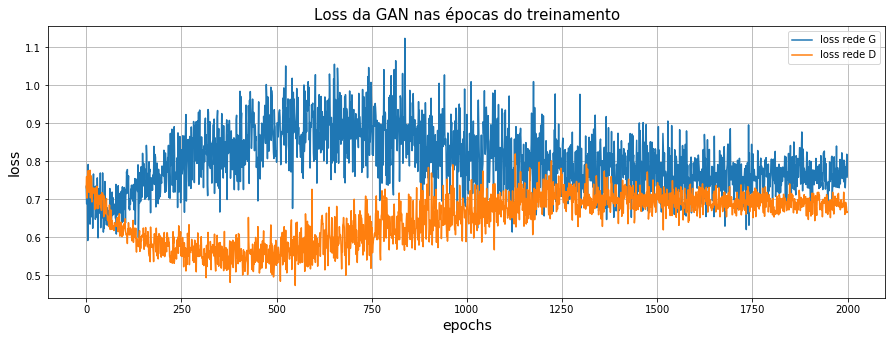

In [354]:
plt.figure(figsize=(15,5))
plt.title("Loss da GAN nas épocas do treinamento", fontsize=15)
plt.plot(range(len(g_loss)), g_loss, label="loss rede G")
plt.plot(range(len(d_loss)), d_loss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

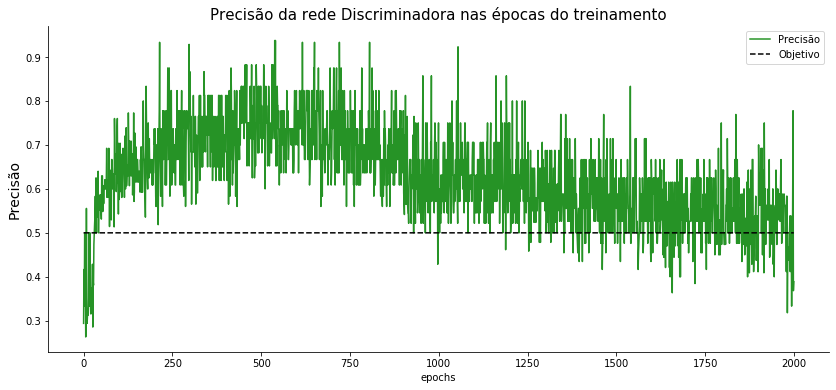

In [355]:
fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot()
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Precisão da rede Discriminadora nas épocas do treinamento", fontsize=15)
plt.xlabel("epochs")
plt.ylabel("Precisão", fontsize=14)
plt.plot(range(len(precision)), precision, color="green", alpha=.85, label="Precisão");
plt.plot(range(len(precision)),np.ones(len(precision))*.5, color="black", ls="--", label="Objetivo");
plt.legend();

(20, 2) (300, 2)


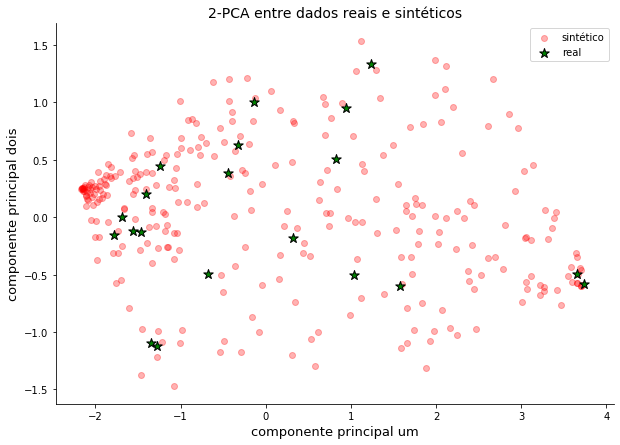

In [356]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
x_noise = G.predict(np.random.normal(loc=0, scale=1, size=(300, noise_input)))
X_sint_pca = pca_real.transform(x_noise)
print(X_train_pca.shape, X_sint_pca.shape)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [357]:
score = []
for i in range(5000):
    X_sint = G.predict(np.random.normal(0, 1, (X_train.shape[0], noise_input)))
    X_test = np.concatenate((X_train, X_sint))
    y_test = np.concatenate((np.ones((X_train.shape[0],1)), np.zeros((X_train.shape[0],1))))
    y_predict = D.predict_classes(X_test)
    score.append(precision_score(y_test, y_predict))

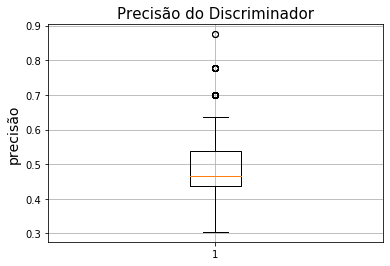

In [358]:
plt.title("Precisão do Discriminador", fontsize=15)
plt.ylabel("precisão", fontsize=14)
plt.grid("y")
plt.boxplot(score);

In [359]:
np.mean(score), np.std(score), np.median(score)

(0.4820576768155268, 0.07382529494937634, 0.4666666666666667)

In [360]:
X_train.shape

(20, 9)

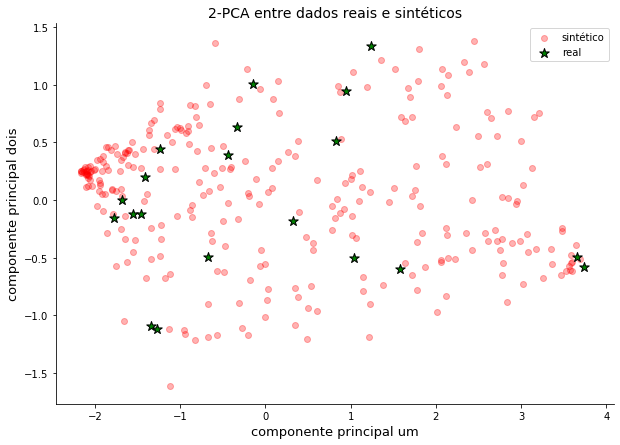

In [363]:
X_sint = G.predict(np.random.normal(0, 1, (300, noise_input)))
X_nov = np.concatenate((X_train.iloc[:14], X_sint))

fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)

X_sint_pca = pca_real.transform(X_sint)

plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="red", label="sintético", alpha=0.3)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [364]:
X_nov.shape

(314, 9)

In [372]:
from sklearn.svm import OneClassSVM
#nu=0.138
clf = OneClassSVM(kernel="rbf", nu=0.01, gamma=.1).fit(X_nov)

print("score no treinamento: ", np.mean(clf.predict(X_nov)==1))
print("score nos genes de referência de treinamento: ", np.mean(clf.predict(X_train.iloc[:14]) == 1))
print("score nos genes de referência no utilizados pro treinamento: ",
     np.mean(clf.predict(X_train.iloc[14:]) == 1))
print("score em todos os genes de referência: ", np.mean(clf.predict(X_train)==1))

score no treinamento:  0.9872611464968153
score nos genes de referência de treinamento:  0.9285714285714286
score nos genes de referência no utilizados pro treinamento:  0.8333333333333334
score em todos os genes de referência:  0.9


In [343]:
#gan.save("./data/best_gan.h5")

In [344]:
datos.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,-1.021960,-0.979435,-1.070980,-0.936075,-0.964250,-1.031994,-0.934337,-0.939543,-0.937269
aaeB,-1.009480,-1.042995,-1.041304,-1.034891,-1.060889,-1.063096,-1.039629,-0.965042,-0.989310
aaeR,-1.006916,-0.996388,-1.082667,-0.987112,-1.078005,-1.014922,-1.058494,-0.940447,0.509951
aaeX,-0.943096,-0.955260,-0.950883,-0.910106,0.425601,-1.000392,-1.010278,-0.964826,0.441659
aas,-0.922192,-0.918634,-0.912901,-0.955073,-0.996782,-0.974946,-0.973578,-0.897515,-0.892211


In [345]:
predict_cand = clf.predict(datos)

In [346]:
cand = datos[predict_cand == 1]
no_cand = datos[predict_cand == -1]
cand.shape, no_cand.shape

((738, 9), (3447, 9))

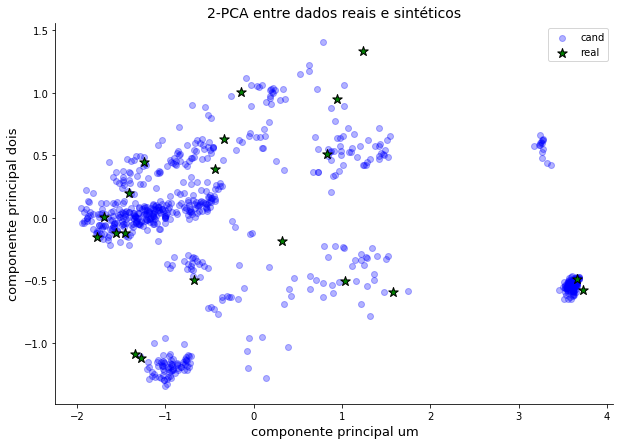

In [347]:
fig2 = plt.figure(figsize=(10,7))
ax2 = fig2.add_subplot()
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
plt.title("2-PCA entre dados reais e sintéticos", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)

X_sint_pca = pca_real.transform(X_sint)
X_cand = pca_real.transform(cand)
X_nocand = pca_real.transform(no_cand)

#plt.scatter(X_nocand[:,0], X_nocand[:,1], color="red", label="no_cand",alpha=.3)
plt.scatter(X_cand[:,0], X_cand[:,1], color="blue", label="cand",alpha=.3)
#plt.scatter(X_sint_pca[:,0], X_sint_pca[:,1], color="green", label="sintéticos",alpha=1, edgecolors="black")
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=1,
            marker="*", edgecolors="black", s=100)
plt.legend();

In [348]:
print("redução do ", (1 - cand.shape[0]/datos.shape[0])*100,"% no processo de escolha de candidatos")

redução do  82.36559139784947 % no processo de escolha de candidatos


In [349]:
obj_rg = open("./data/RG_artigoMoose.txt")
rg_moose = [g for g in obj_rg.read().splitlines()]
print("Genes candidatos do artigo moose:", len(rg_moose))
print(rg_moose)

Genes candidatos do artigo moose: 27
['dnaG', 'dtpB', 'ftsX', 'ftsY', 'glyY', 'gyrB', 'lhr', 'mutM', 'mutY', 'ndk', 'nfuA', 'pnp', 'rbbA', 'rhsB', 'rpsU', 'rrsE', 'rrsG', 'secB', 'spoT', 'tfaR', 'thrW', 'valS', 'yedJ', 'ynaE', 'yphG', 'zntA', 'zupT']


In [350]:
datos.loc[cand.loc[rg_moose].dropna().index]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
dtpB,-0.790432,-0.815620,0.621418,0.649137,0.668417,0.679104,0.613943,0.632987,0.645587
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720


In [351]:
print(cand.loc[rg_moose].dropna().shape[0])
cand.loc[rg_moose].dropna()

12


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
dtpB,-0.790432,-0.815620,0.621418,0.649137,0.668417,0.679104,0.613943,0.632987,0.645587
ftsX,0.695567,0.657817,0.714709,0.703786,0.689007,0.679817,0.627045,0.635738,0.648512
ftsY,0.734632,0.733591,0.794660,-0.650803,0.759634,0.736101,0.682666,0.613599,0.705083
glyY,0.325490,0.336130,0.440474,0.471258,0.417251,0.299939,0.240026,-0.008847,0.235020
mutY,0.708679,0.703653,0.720573,0.741906,-0.724643,0.700263,0.635943,0.599778,0.676169
ndk,-0.281602,-0.242767,-0.128360,-0.089681,-0.134461,-0.211738,-0.192042,1.009335,-0.286640
nfuA,0.905821,0.899027,0.987680,0.991985,0.981116,0.875800,0.849890,0.711463,0.841314
rrsE,0.587656,0.604759,0.693686,0.763962,0.745445,0.692236,0.564757,0.333634,0.588330
rrsG,-0.340691,-0.307542,-0.218399,-0.166913,-0.192341,-0.278790,-0.419332,0.789914,-0.380720


In [338]:
obj_edi = open("data/RG_artigoEdian.txt")
rg_edi = [g for g in obj_edi.read().splitlines()]
print("Genes candidatos do artigo edian:", len(rg_edi))
print(rg_edi)

Genes candidatos do artigo edian: 17
['bamD', 'efp', 'gatB', 'gatD', 'hfq', 'nusA', 'polA', 'prc', 'prfB', 'ptsN', 'rimP', 'rplP', 'rpsC', 'rpsO', 'rpsU', 'slyD', 'ychF']


In [339]:
cand.loc[rg_edi].dropna()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  """Entry point for launching an IPython kernel.


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
gatD,0.797513,0.779422,0.864410,0.888021,0.879034,0.811774,0.696794,0.558069,0.723031
ptsN,0.788705,0.766796,0.808711,0.881338,0.850952,0.785160,0.660781,0.588654,0.714060
